In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("../resources/data/discords/stock/stock_20_0.txt",header=None,names=['values'])
df

values
0     18.680
1     18.680
2     18.680
3     18.670
4     18.670
...      ...
4995  18.490
4996  18.550
4997  18.547
4998  18.500
4999  18.450

[5000 rows x 1 columns]

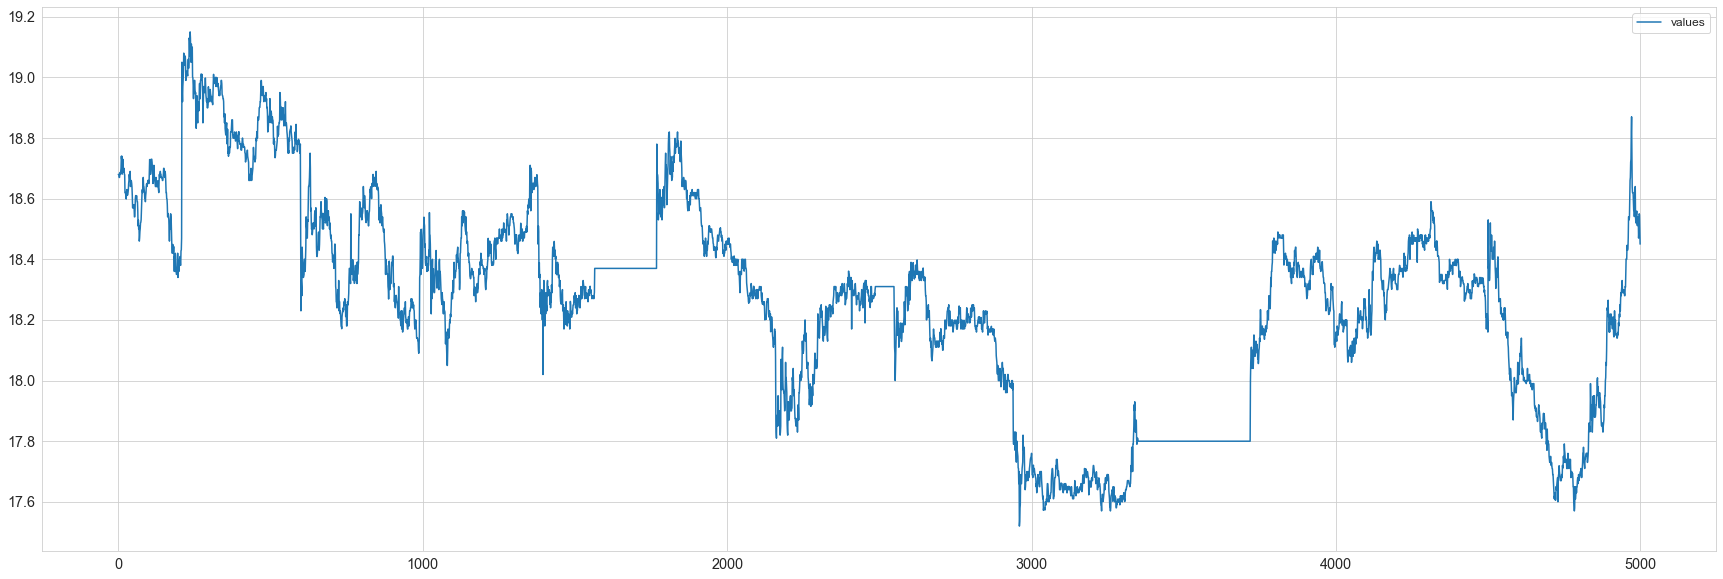

In [3]:
df.plot(figsize=(30,10))
plt.show()

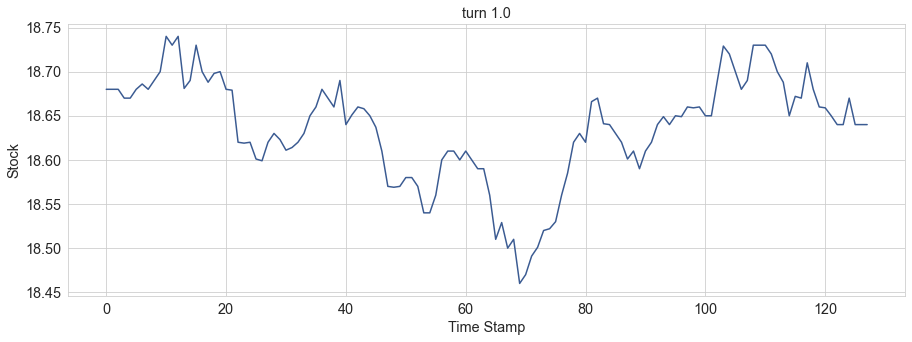

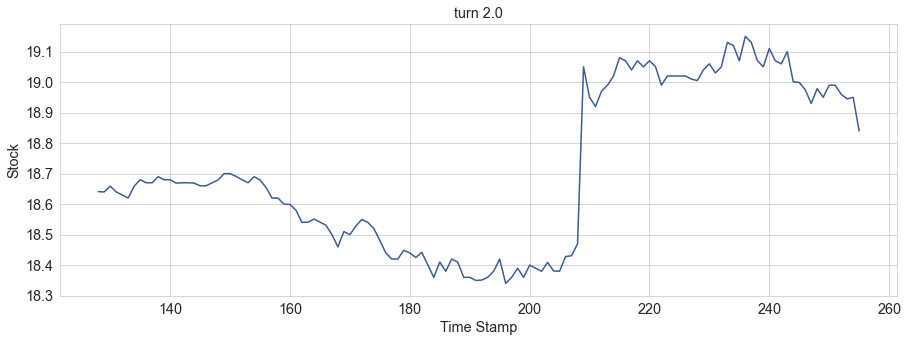

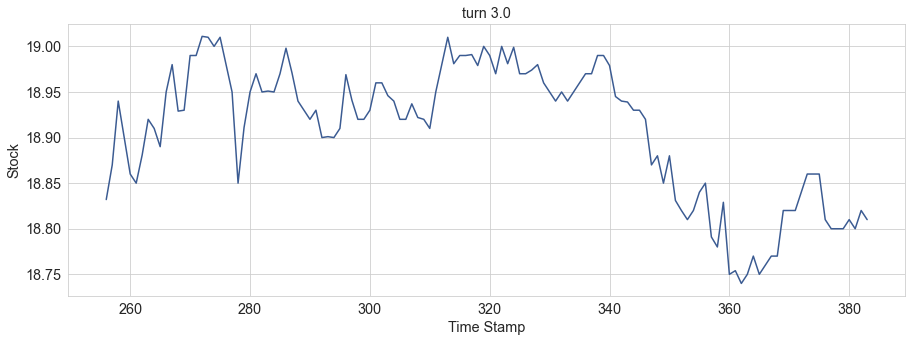

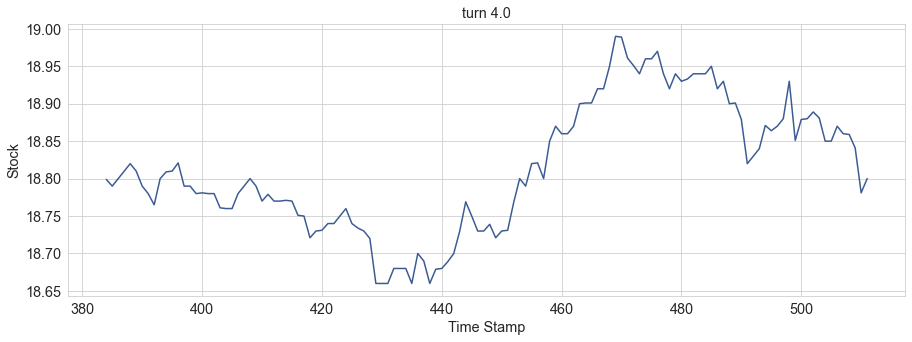

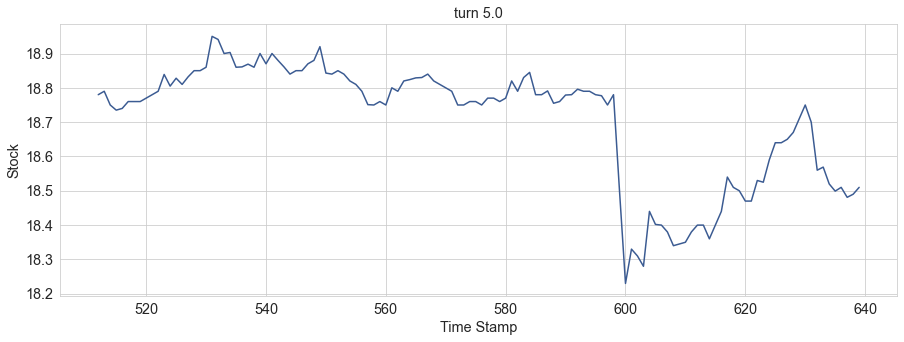

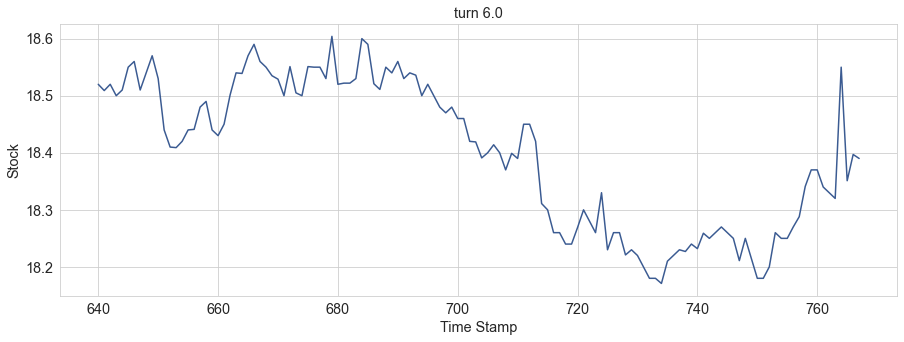

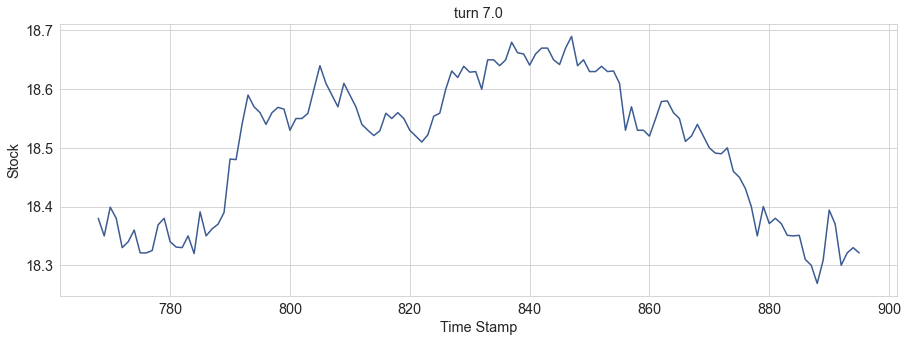

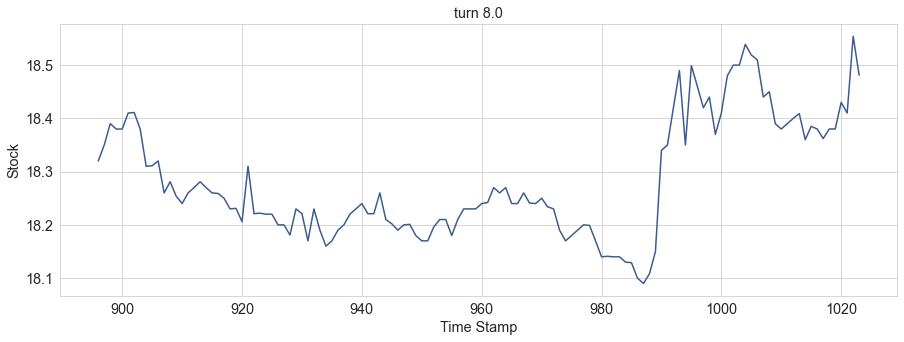

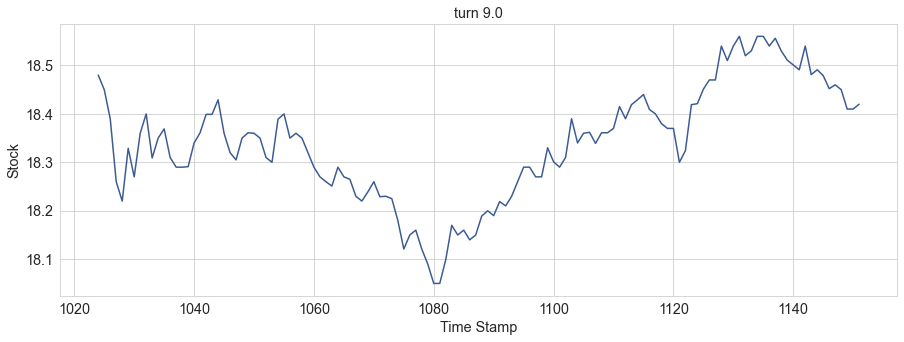

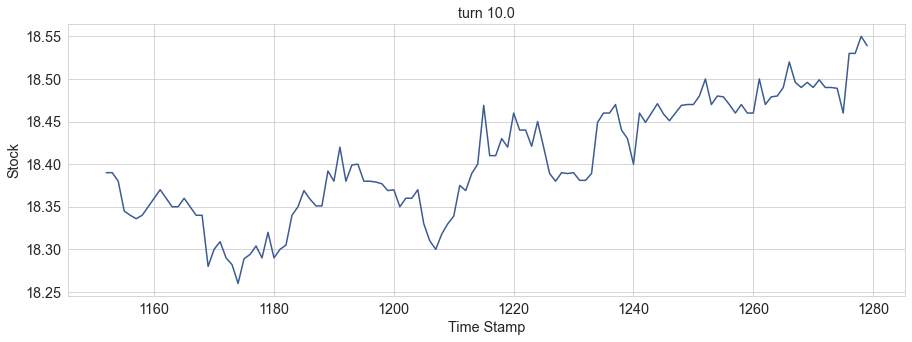

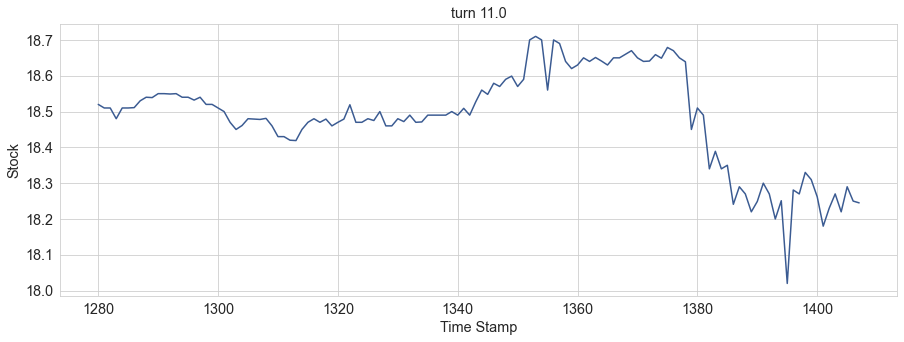

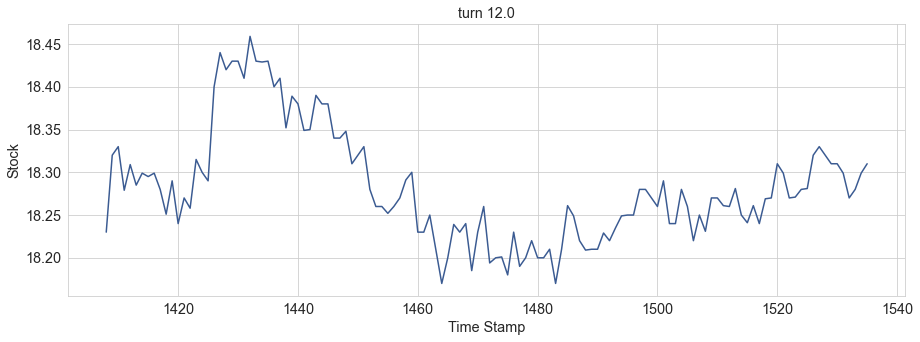

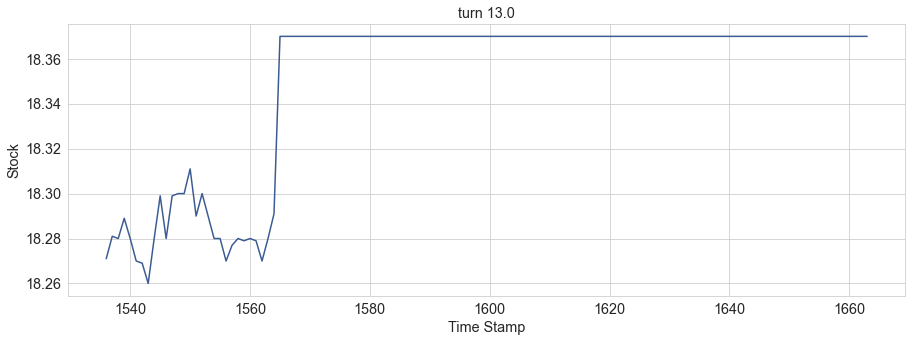

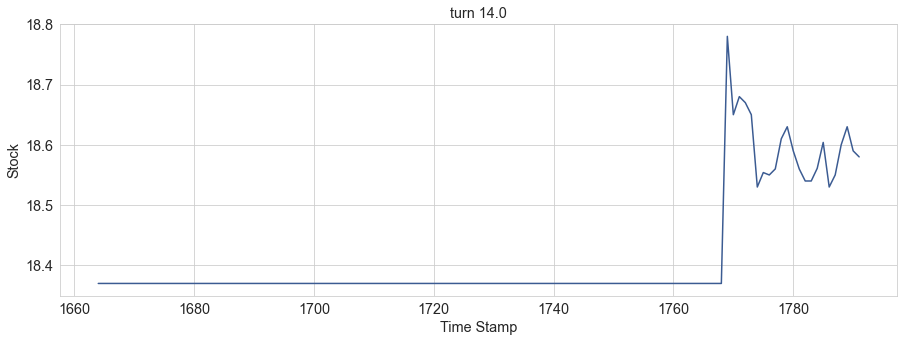

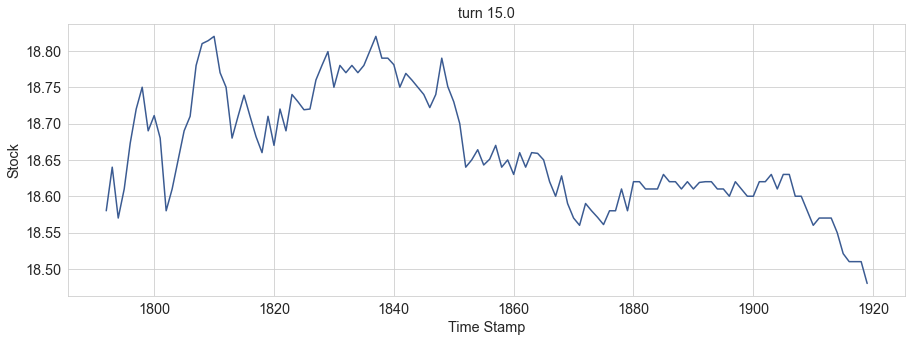

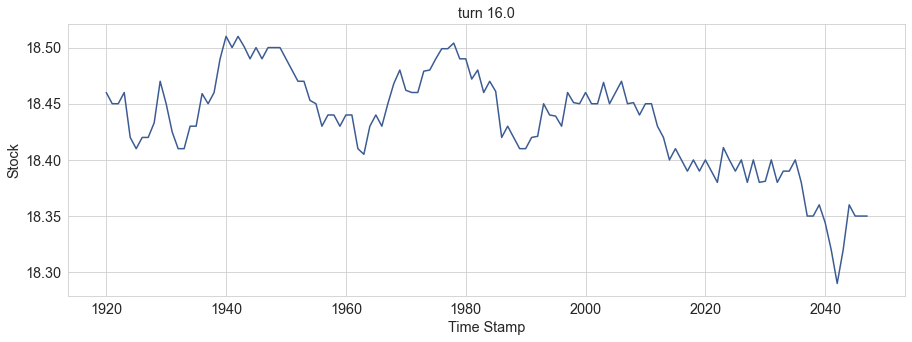

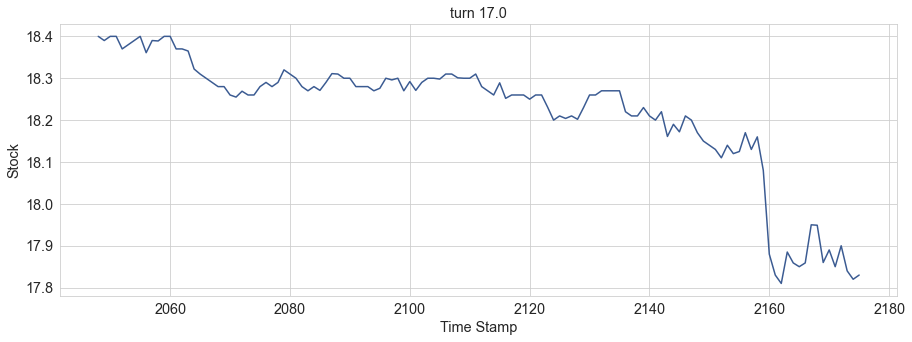

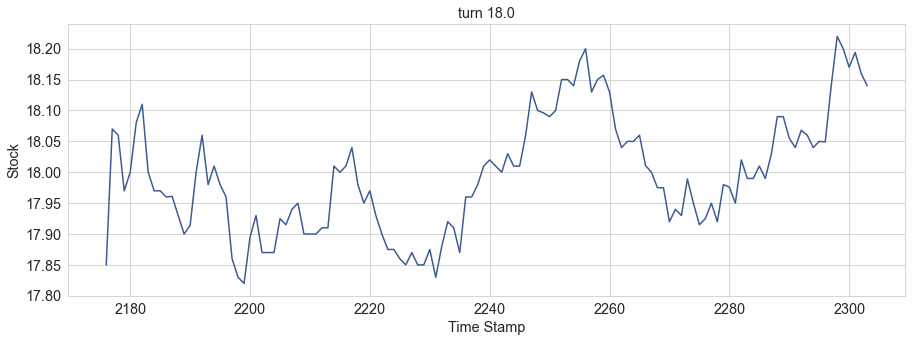

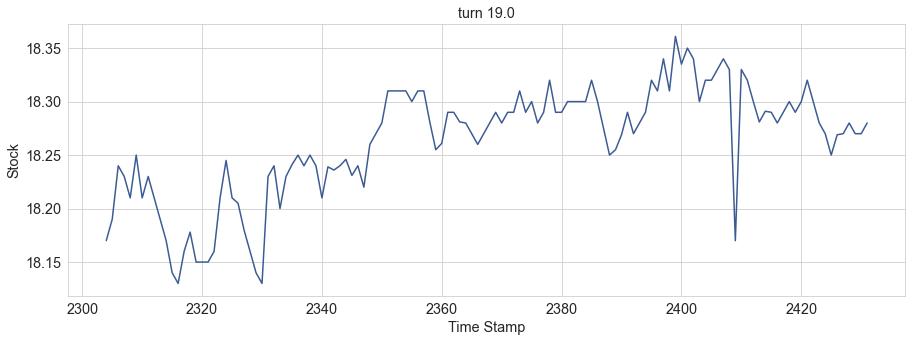

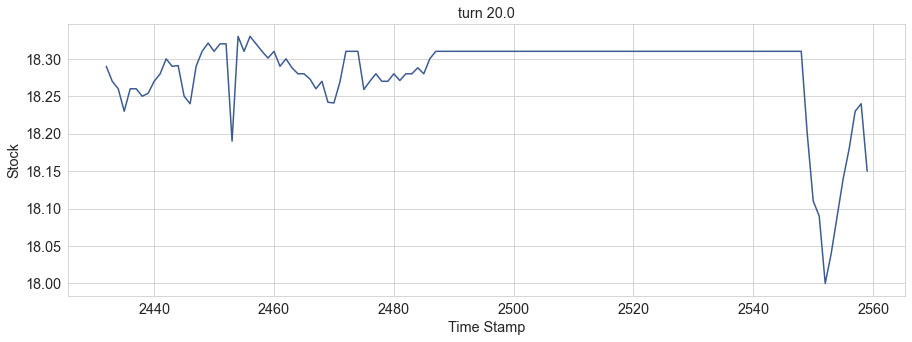

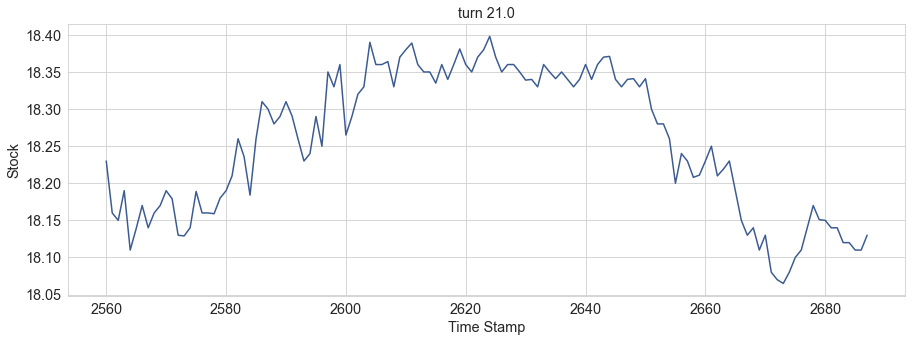

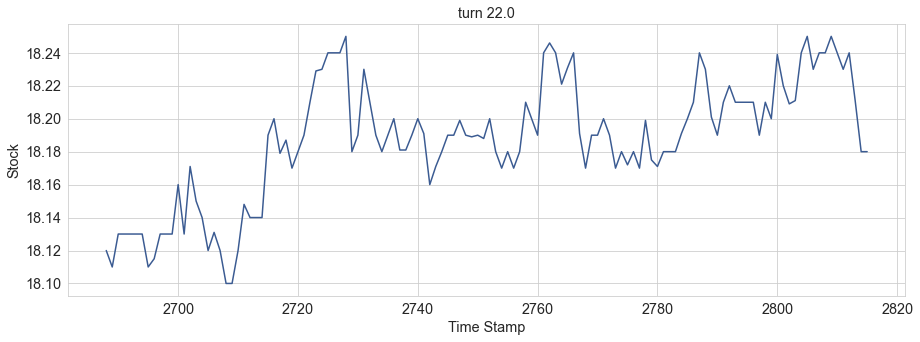

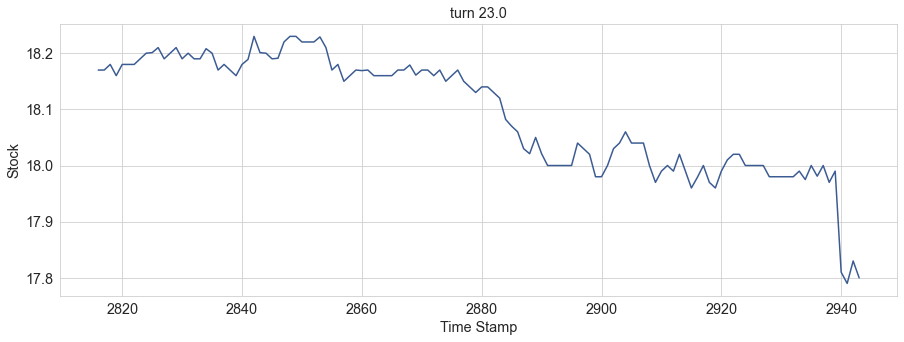

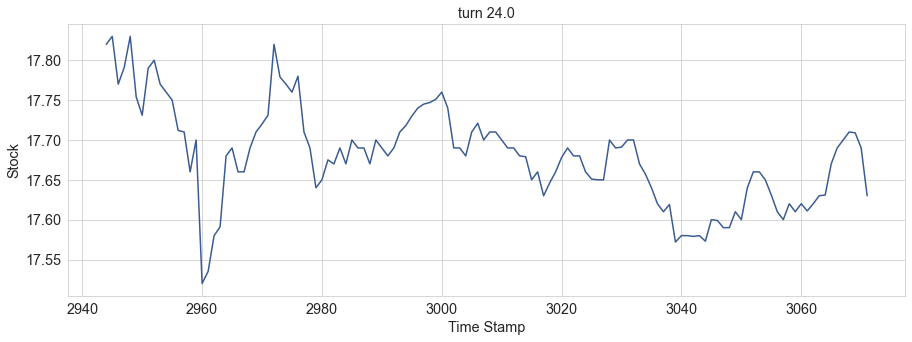

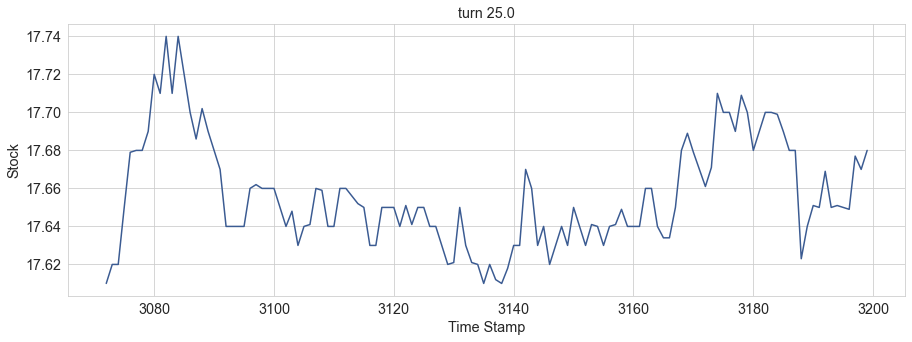

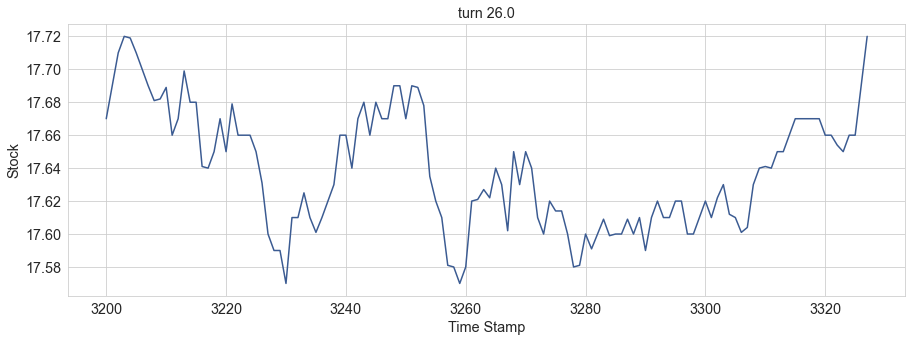

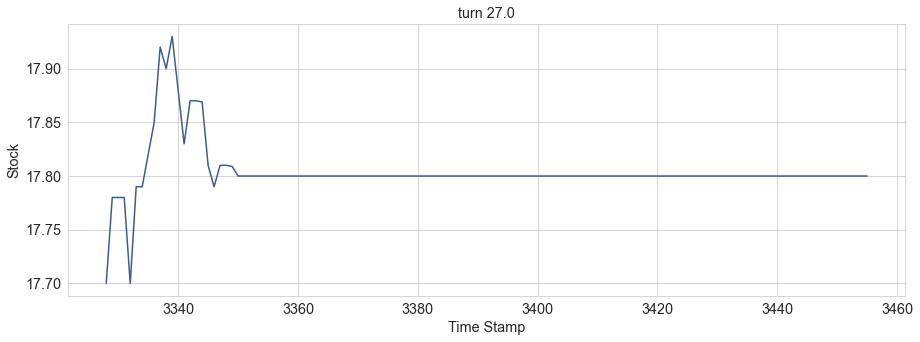

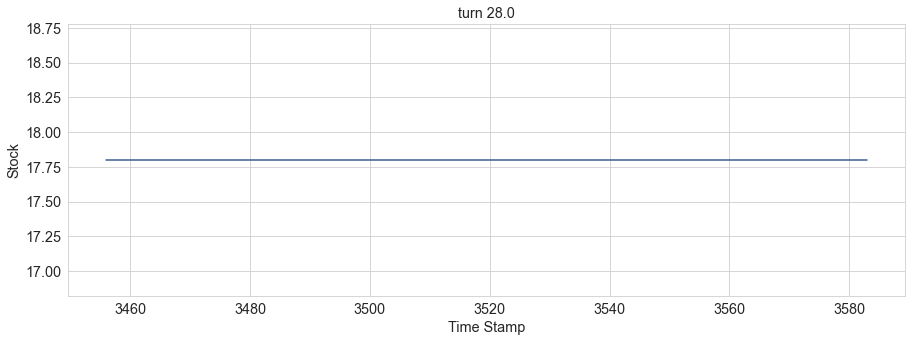

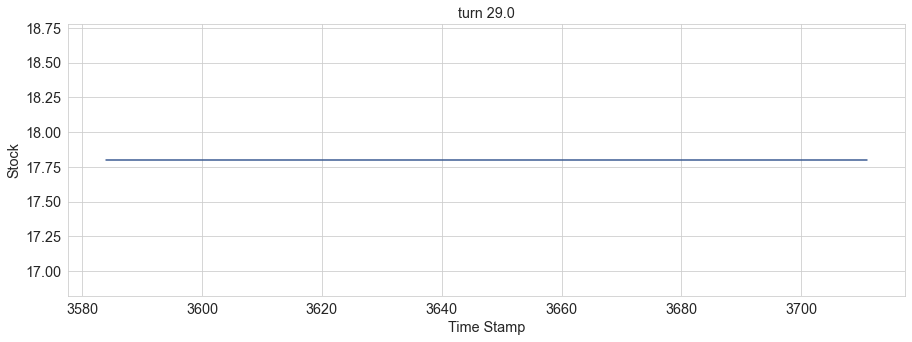

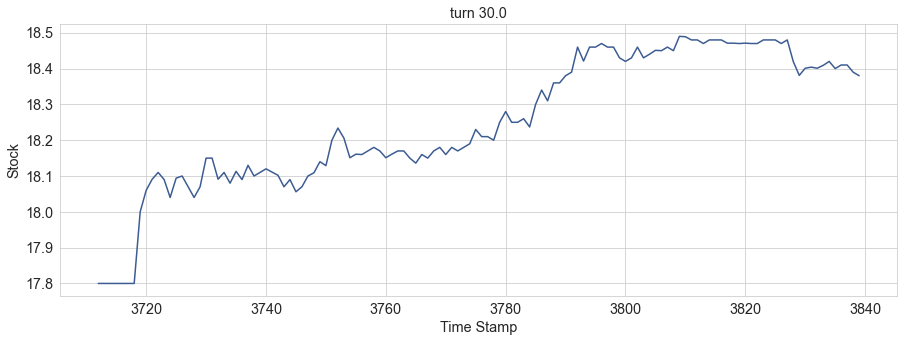

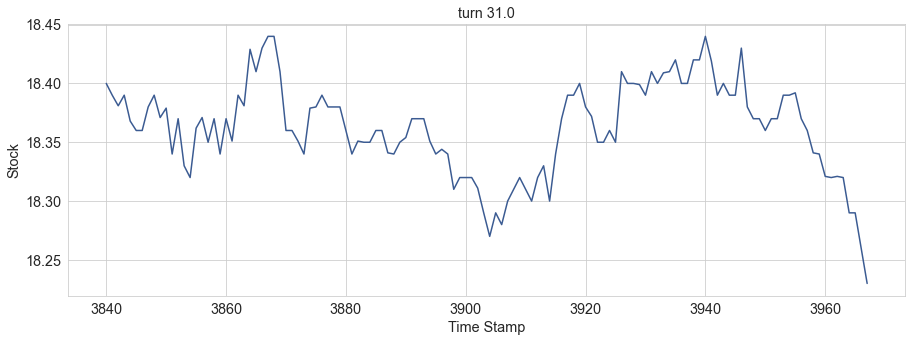

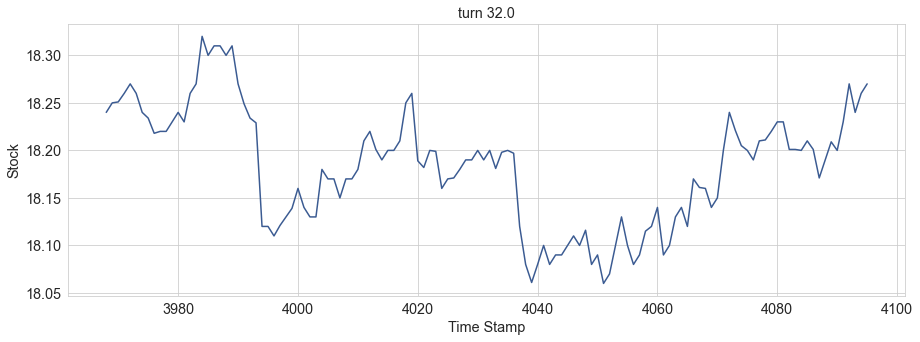

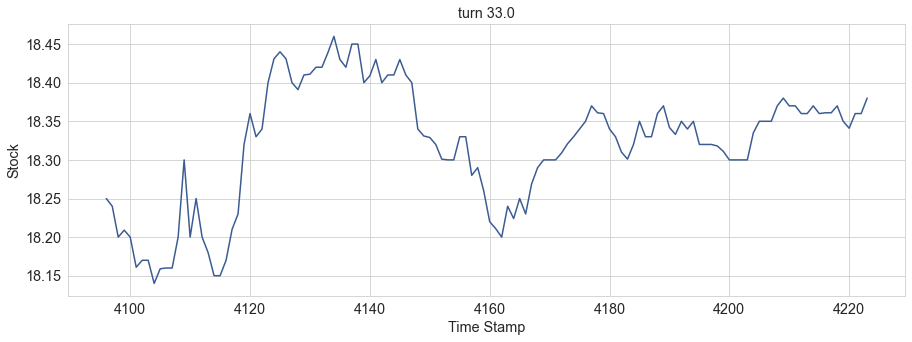

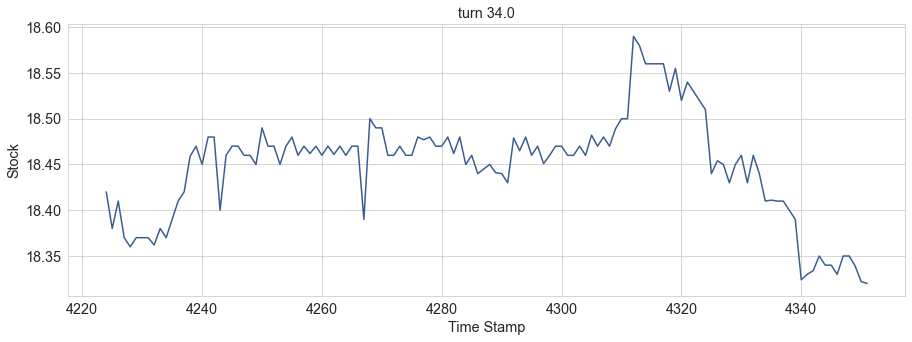

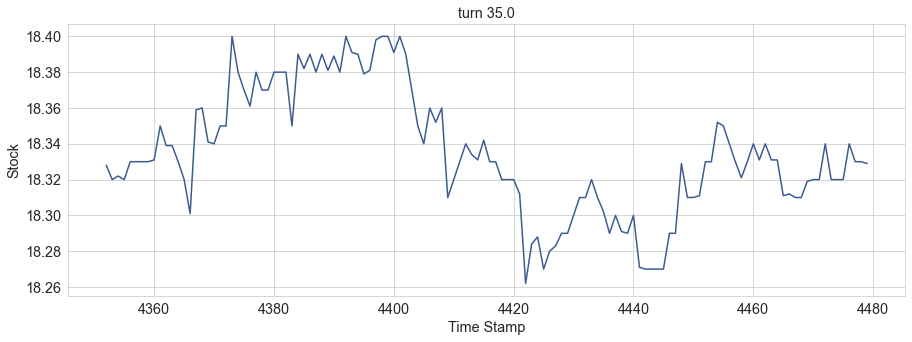

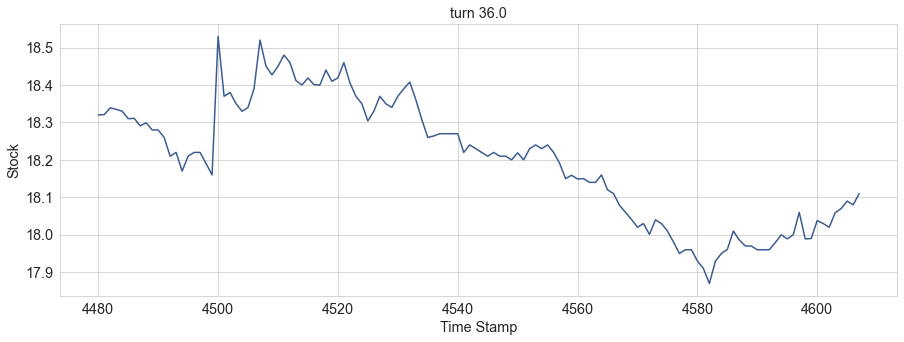

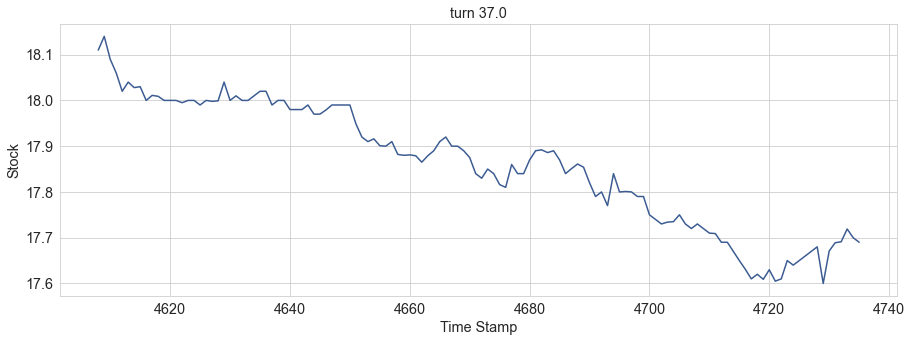

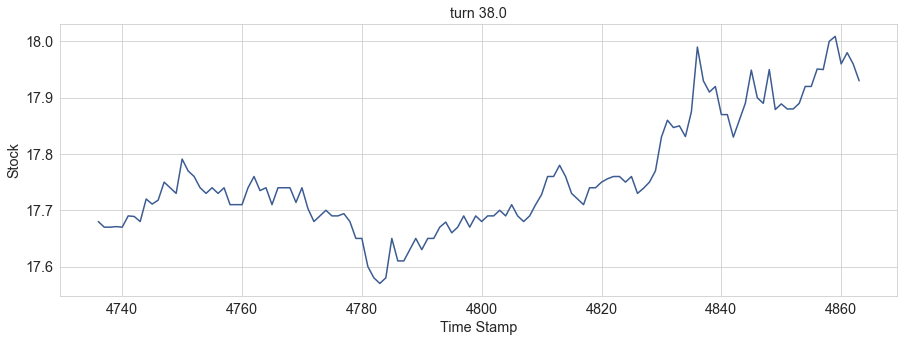

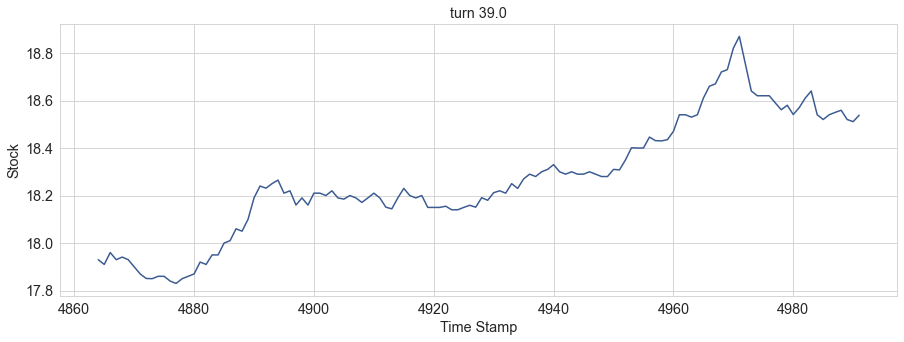

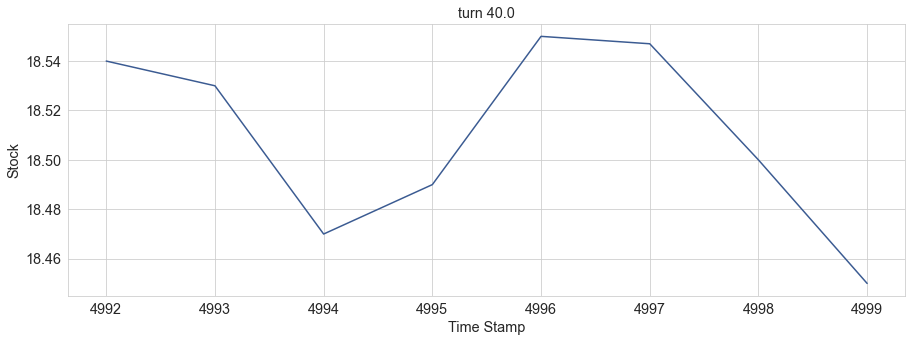

In [4]:
step = 128

for i in range(0,df.shape[0],step):
    fig = plt.figure(figsize=(15,5))
    tmp = df[i:i+step]['values'].plot(color=sns.xkcd_rgb["denim blue"])
    plt.title("turn %s"%(i/step +1))
    plt.xlabel('Time Stamp')
    plt.ylabel('Stock')
    plt.show()
    pp = PdfPages("turn_%s.pdf"%(i/step +1))
    pp.savefig(fig)
    pp.close()

Size of train: (4235, 2)
Size of test: (265, 2)
Size of validation1: (500, 2)
Size of validation2: (265, 2)
Total: 5265
Ratio of train: 0.804368
Ratio of test: 0.050332
Ratio of validation1: 0.094967
Ratio of validation2: 0.050332


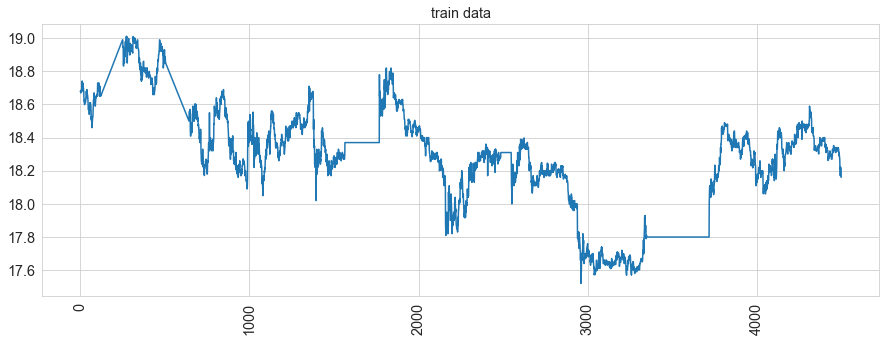

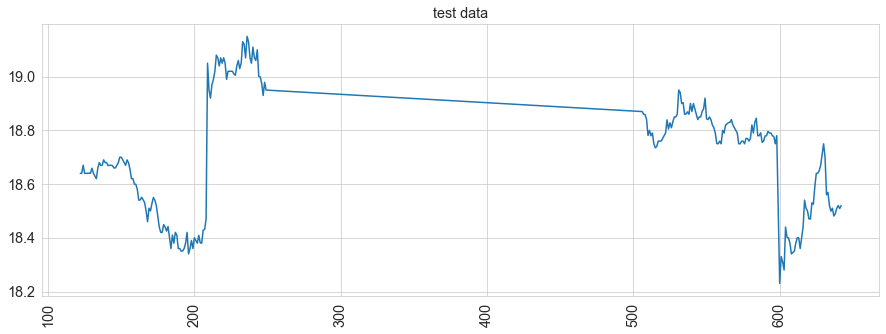

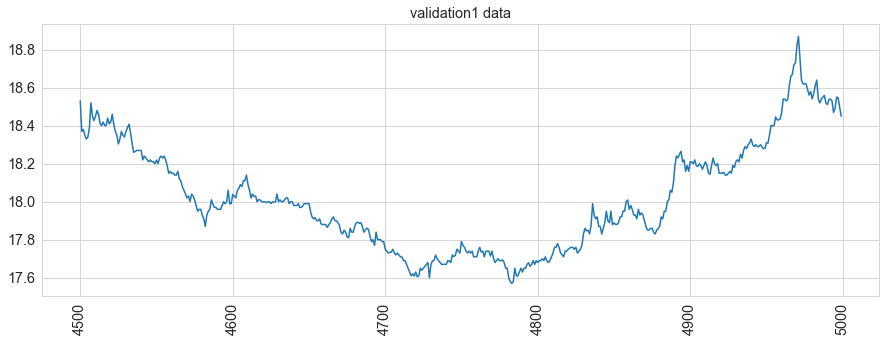

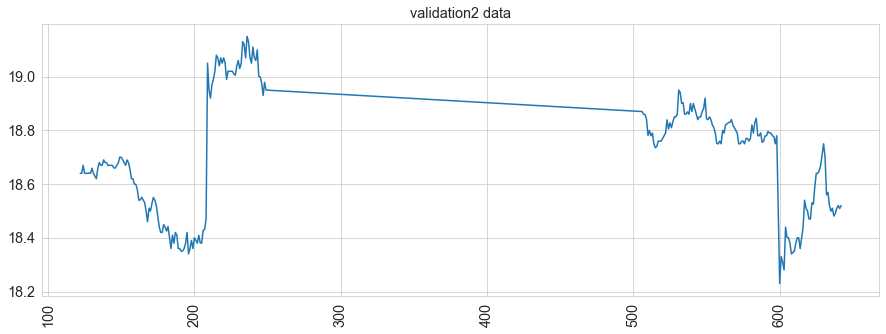

   values  anomaly
0   18.68      0.0
1   18.68      0.0
2   18.68      0.0
3   18.67      0.0
4   18.67      0.0


In [5]:
df['anomaly'] = 0

df_anomaly1 = df[122:250]
# df_anomaly2 = df[365:493]
df_anomaly3 = df[506:643]
df_test = pd.concat([df_anomaly1,df_anomaly3])
df_validation1= df[4500:]

df_not_train = pd.concat([df_validation1,df_test])
df_train = df[~df.isin(df_not_train)].dropna()
df_validation2 = df_test

df_dict = {}
df_dict['train'] = df_train
df_dict['test'] = df_test
df_dict['validation1'] = df_validation1
df_dict['validation2'] = df_validation2

count = 0
for key in df_dict:
    print("Size of %s: %s"%(key,df_dict[key].shape))
    count += df_dict[key].shape[0]
print("Total: %d"%(count))

for key in df_dict:
    print("Ratio of %s: %f"%(key,float(df_dict[key].shape[0])/count))

    
for key in df_dict:
    df_tmp = df_dict[key]
    plt.figure()
    df_tmp['values'].plot(figsize=(15,5))
    rows = df_tmp[df_tmp.anomaly.isin([1])].itertuples()
    for row in rows:
        print(row)
        plt.plot(row[0], row[1], 'r.', markersize=10.0)
    plt.xticks(rotation='vertical')
    plt.title("%s data"%(key))
    plt.show()
print(df_train.head())

In [6]:
discords = [122,506]
step = 128
for item in discords:
  df[item:item+step]['anomaly'] =1

df

<ipython-input-6-a635e1c45e20>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[item:item+step]['anomaly'] =1


values  anomaly
0     18.680        0
1     18.680        0
2     18.680        0
3     18.670        0
4     18.670        0
...      ...      ...
4995  18.490        0
4996  18.550        0
4997  18.547        0
4998  18.500        0
4999  18.450        0

[5000 rows x 2 columns]

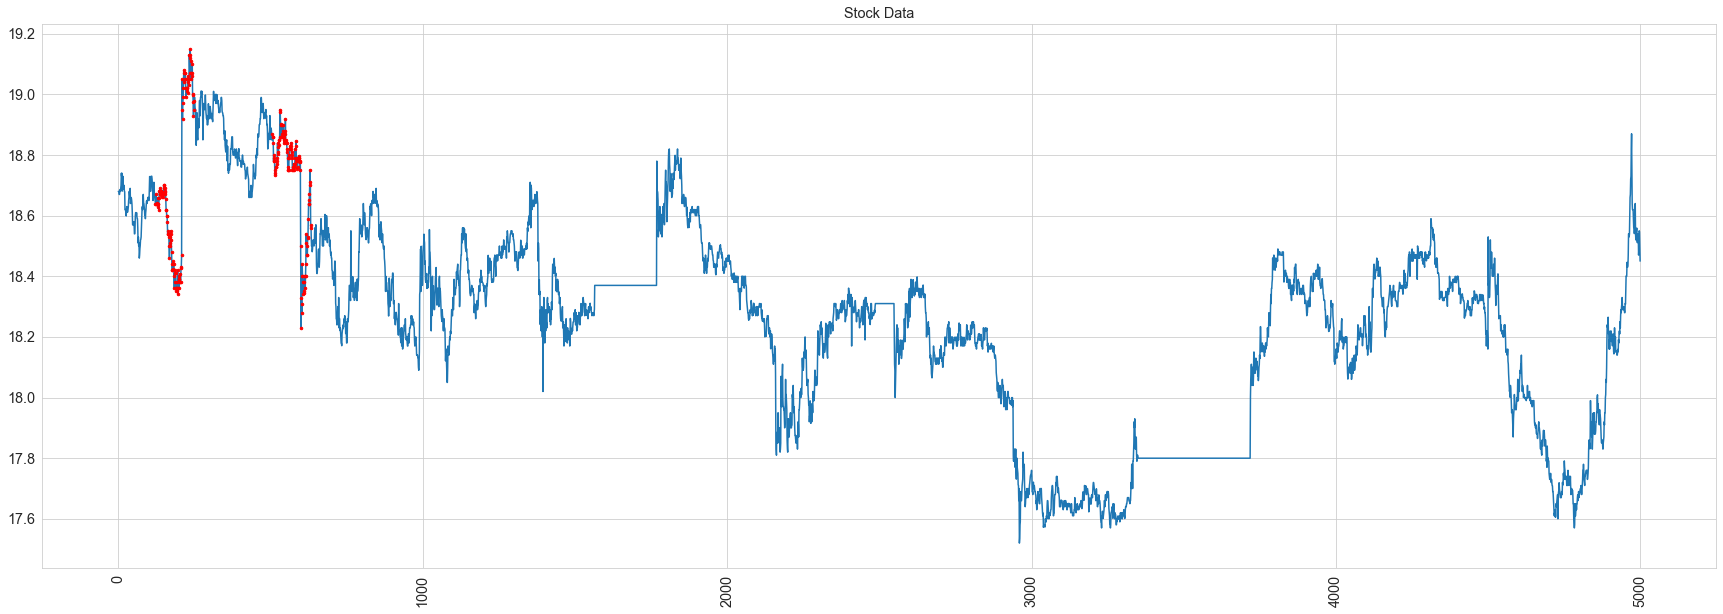

In [7]:
plt.figure()
df_tmp = df
df_tmp['values'].plot(figsize=(30,10))
rows = df_tmp[df_tmp.anomaly.isin([1])].itertuples()
for row in rows:
    plt.plot(row[0], row[1], 'r.', markersize=5.0)
plt.xticks(rotation='vertical')
plt.title("Stock Data")
plt.show()

In [9]:
for key in df_dict:
    np.save("../resources/data/discords/stock/%s"%(key),df_dict[key])

### Part 2: Prediction Modeling
Use python scripts: *lstm_predictor.py , stateful_lstm_predictor.py*.

### Part 3: Anomaly Detection

In [19]:
data_folder = "../resources/data/discords/stock/"

In [20]:
#load training data
train_predictions = np.load(data_folder+"train_predictions.npy")
train_true = np.load(data_folder+"train_true.npy")
print(train_predictions.shape)
print(train_true.shape)


(4227, 3)
(4227,)


In [21]:
#load validation2 data
validation2_predictions = np.load(data_folder+"validation2_predictions.npy")
validation2_true = np.load(data_folder+"validation2_true.npy")
validation2_labels = np.load(data_folder+"validation2_labels.npy")
print(np.shape(validation2_predictions))
print(np.shape(validation2_true))
print(np.shape(validation2_labels))
validation2_labels = np.reshape(validation2_labels,[len(validation2_labels),np.shape(validation2_labels)[1]])
print(np.shape(validation2_labels))


(257, 3)
(257,)
(257, 3, 1)
(257, 3)


In [22]:
# load test data
test_predictions = np.load(data_folder+"test_predictions.npy")
test_true = np.load(data_folder+"test_true.npy")
test_labels = np.load(data_folder+"test_labels.npy")
print(np.shape(test_predictions))
print(np.shape(test_true))
test_labels = np.reshape(test_labels,[len(test_labels),np.shape(test_labels)[1]])
print(np.shape(test_labels))

(257, 3)
(257,)
(257, 3)


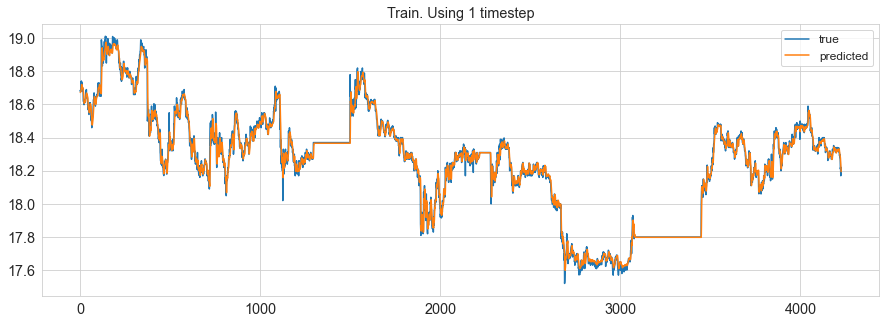

In [23]:
plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
# plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()
plt.title("Train. Using 1 timestep")
plt.show()

[-0.00029741 -0.00041047 -0.00052043]
[[0.00119074 0.00135815 0.00140076]
 [0.00135815 0.00172373 0.00187907]
 [0.00140076 0.00187907 0.00223255]]


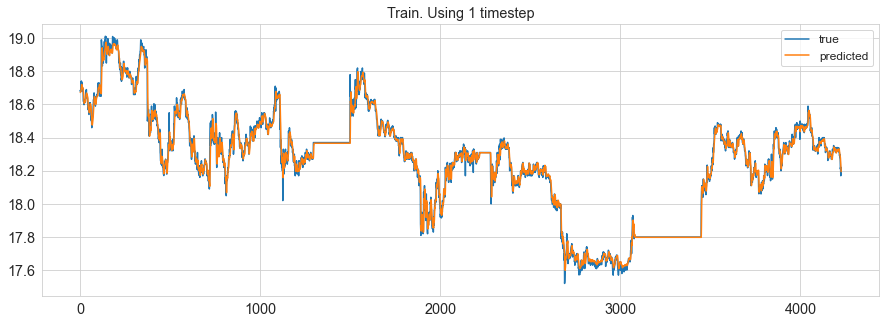

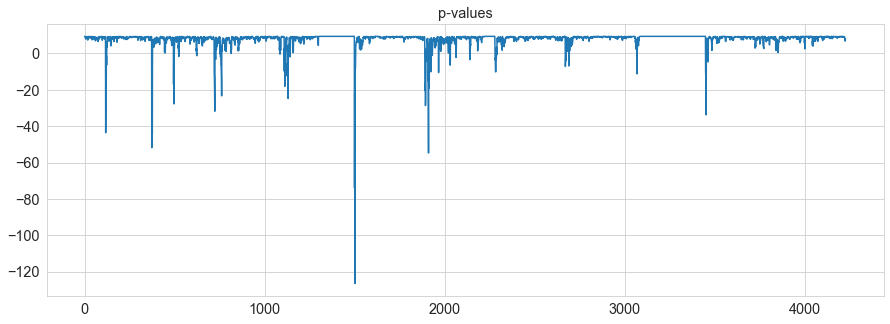

In [24]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
n_cols = np.shape(train_predictions)[1]
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]

mean = np.mean(train_error_vectors, axis=0)
cov = np.cov(train_error_vectors,rowvar=False)
print(mean)
print(cov)
p_values= multivariate_normal.logpdf(train_error_vectors,mean,cov)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
# plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.title("Train. Using 1 timestep")
plt.legend()

# plt.figure(figsize=(15,5))
# plt.plot(train_true,label='true')
# plt.plot(train_predictions[:,5],label='predicted')
# plt.plot(abs(train_true - train_predictions[:,5]),label='error')
# plt.title("Train. Using 6 timestep")
# plt.legend()

plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

train_errors_1 = train_true - train_predictions[:,0]

In [25]:
v2_error_vectors = np.zeros(np.shape(validation2_predictions))
for i in range(n_cols):
    v2_error_vectors[:,i] =  validation2_true -validation2_predictions[:,i]
v2_p_values= multivariate_normal.logpdf( v2_error_vectors,mean,cov)
# v2_true_anomalies = np.where(validation2_labels[:,0]==1)
# print "Validation2. Number True Anomalies: %d"%(np.shape(v2_true_anomalies)[1])
# print "Validation2. Location of anomalies: %s"%(v2_true_anomalies)
# print "validation2. True anomalies: %s"%(validation2_true[v2_true_anomalies])
# v2_thresholds =v2_p_values[v2_true_anomalies]
# print "validation2. p-values at true anomalies: %s"%(v2_thresholds)

# print 
test_error_vectors = np.zeros(np.shape(test_predictions))
for i in range(n_cols):
    test_error_vectors[:,i] =  test_true -test_predictions[:,i]
test_p_values= multivariate_normal.logpdf( test_error_vectors,mean,cov)
test_true_anomalies = np.where(test_labels[:,0]==1)
# print "Test. Number True Anomalies in: %d"%(np.shape(test_true_anomalies)[1])
# print "Test. Location of anomalies: %s"%(test_true_anomalies)
# print "Test. True anomalies: %s"%(test_true[test_true_anomalies])
# test_thresholds = test_p_values[test_true_anomalies]
# print "Test. p-values at true anomalies: %s"%(test_thresholds)




[ 82  83  84  85  86  87 216 217 218 219 220 221]


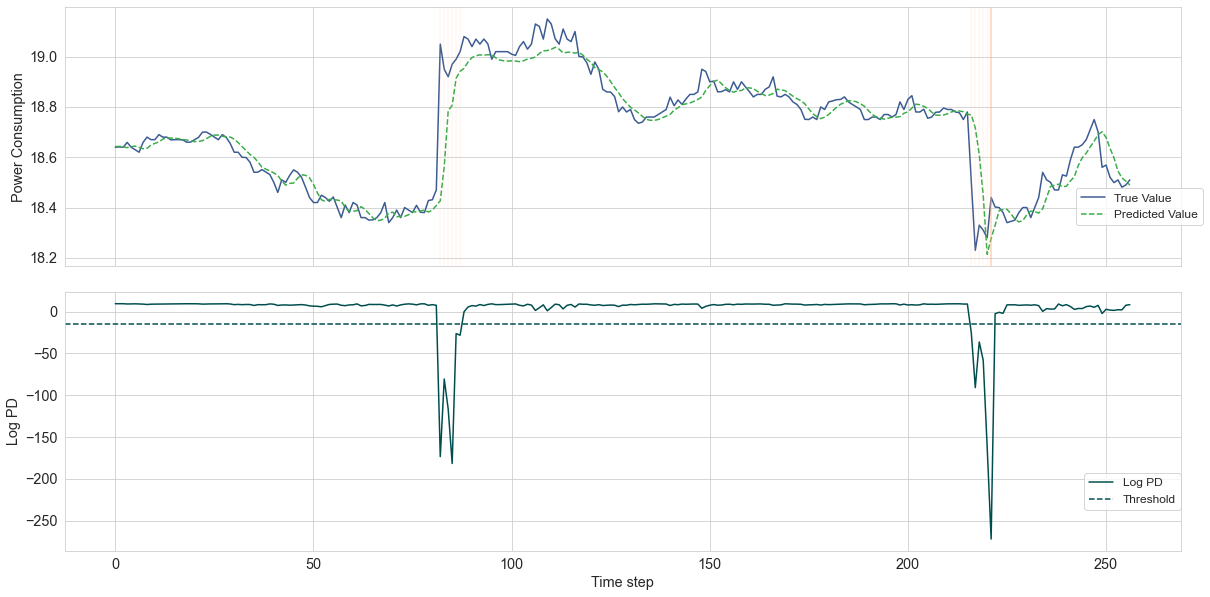

In [26]:
threshold_v2 = -15
f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)

v2_below_threshold = np.where(v2_p_values <= threshold_v2)
ax1 = plt.subplot(211)
ax1.plot(validation2_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(validation2_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
# ax1.plot(abs(validation2_true - validation2_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in v2_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=.1)
print(v2_below_threshold[0])
ax1.axvline(x=v2_below_threshold[0][-1],color=sns.xkcd_rgb["peach"],alpha=.5)
#for row in v2_true_anomalies:
#    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
ax1.legend(bbox_to_anchor=(1.02,.3),borderaxespad=0.,frameon=True)
plt.ylabel("Power Consumption")
#plt.title("Validation2. Using 1 timestep")


#plot v2 log PD
ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(v2_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
ax2.legend(bbox_to_anchor=(1, .3), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#plt.title("Validation2 p-values")

#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()
pp = PdfPages('power_v2.pdf')
pp.savefig(f)
pp.close()

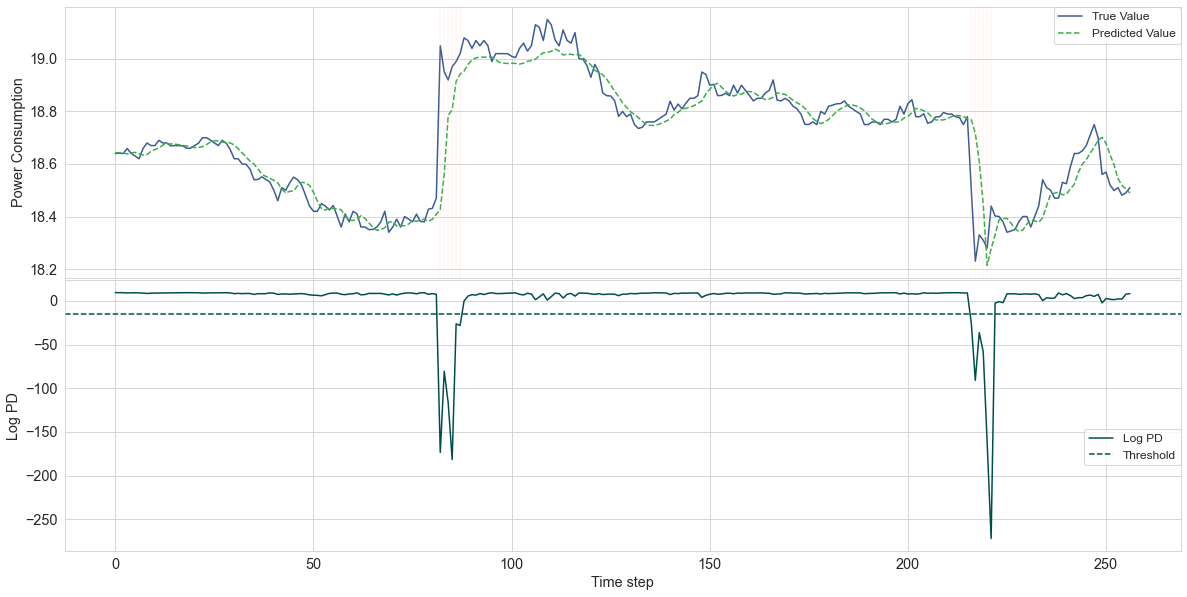

In [27]:
test_below_threshold = np.where(test_p_values <= threshold_v2)
#plot test data
f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.01)

ax1 = plt.subplot(211)
ax1.plot(test_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(test_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
# ax1.plot(abs(test_true - test_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in test_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=0.1)
#for row in test_true_anomalies:
#    plt.plot(row, test_true[row], 'r.', markersize=20.0)
ax1.legend(bbox_to_anchor=(1, 1), borderaxespad=0.,frameon=True)
plt.ylabel("Power Consumption")
#plt.title("Test. Using 1 timestep")

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(test_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
ax2.legend(bbox_to_anchor=(1, .45), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#plt.title("test p-values")

#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()
pp = PdfPages('power_test.pdf')
pp.savefig(f)
pp.close()